# Package import

In [1]:
from math import cos, sin, tan
import random

from IPython.display import display, Math, HTML, Pretty
import IPython.display as Display

import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify
sp.init_printing()

Symbolic = {}

# 基本的なユーティリティ関数

In [2]:
def _subs(EXPR, repl):
    return EXPR.subs(repl, simultaneous=True)

def __M32__(ARGS, EXPR):
    f = lambdify(ARGS, EXPR, 'numpy')
    return lambda *args: np.array(f(*args), dtype=np.float32)

def __V32__(ARGS, EXPR):
    f = __M32__(ARGS, EXPR)
    return lambda *args: f(*args).reshape((len(ARGS),))

Symbolic['M32'] = __M32__
Symbolic['V32'] = __V32__

def rand(n):
    return [ random.uniform(-1, 1) for _ in range(0, n) ]

def md(*args):
    s = ''
    for x in args:
        if (isinstance(x, sp.Basic) or isinstance(x, sp.MutableDenseMatrix)):
            s = s + sp.latex(x)
        elif (isinstance(x, str)): s = s + x
        else: print(type(x))
    Display.display_markdown(s, raw=True)

## ベクトルの扱い

ベクトルの定義

In [3]:
# 数式としてのベクトルの雛形の定義
sp.var('x y z w')

_VEC2 = sp.Matrix([x, y])
_VEC3 = sp.Matrix([x, y, z])
_VEC4 = sp.Matrix([x, y, z, w])
def _VEC(name, n): return sp.MatrixSymbol(name, n, 1)

def Vec(n, name):     return sp.MatrixSymbol(sp.Symbol(name), n, 1)
def Vec2(X, Y):       return _subs(_VEC2, {x: X, y: Y})
def Vec3(X, Y, Z):    return _subs(_VEC3, {x: X, y: Y, z: Z})
def Vec4(X, Y, Z, W): return _subs(_VEC4, {x: X, y: Y, z: Z, w: W})

# SymPyから自動生成したベクトル定義モジュール
Symbolic['vec2'] = Symbolic['V32']((x, y), _VEC2)
Symbolic['vec3'] = Symbolic['V32']((x, y, z), _VEC3)
Symbolic['vec4'] = Symbolic['V32']((x, y, z, w), _VEC4)

# Pythonで普通に定義したベクトル定義モジュール
def vec2(x, y): return np.array([x, y], dtype=np.float32)
def vec3(x, y, z): return np.array([x, y, z], dtype=np.float32)
def vec4(x, y, z, w): return np.array([x, y, z, w], dtype=np.float32)
def vec(*args):       return np.array(args, dtype=np.float32).T

# ベクトルの正規化
def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0: return v
    return v/norm

# ふたつの実装が一致することの確認
__nums = [3, 4, 5, 6]
assert np.array_equal(vec2(*__nums[0:2]), Symbolic['vec2'](*__nums[0:2]))
assert np.array_equal(vec3(*__nums[0:3]), Symbolic['vec3'](*__nums[0:3]))
assert np.array_equal(vec4(*__nums),      Symbolic['vec4'](*__nums))

## 同次座標系 (Homogeneous coordinate system)


三次元デカルト座標系(*Cartesian coordinate system*)における点の座標$(x, y, z)$の**同次座標**(*Homogeneous coordinate*)は，任意の非零実数$w$を用いて，$(wx, wy, wz, w)$で表します．

逆に，同次座標$(x, y, z, w)$のデカルト座標は$(x/w, y/w, z/w)$で与えられます．同次座標を用いた座標系のことを**同次座標系**(*Homogeneous coordinate system*)と呼びます．

In [4]:
def Homogeneous(p, w=1):
    return (p * w).col_join(sp.Matrix([w]))

def Cartesian(h):
    return h[0:3,-1] / h[3,0]

if __name__ == '__main__':
    p = Vec3(x, y, z)
    assert sp.Eq(p, Cartesian(Homogeneous(p, w=w)))

### Pythonコード
以下に同次座標系とデカルト座標系の相互変換を行うためのPythonの関数を定義します．

In [5]:
def homogeneous(cp, w=1):
    return np.hstack((cp * w, [w]))
#   return np.array(np.vstack((cp * w, [w])))

def cartesian(hp):
    return hp[0:3] / hp[3]

if __name__ == '__main__':
    p = vec3(1, 2, 3)
    assert np.array_equal(np.array(np.array(Homogeneous(Vec3(1, 2, 3))), dtype=np.float32).reshape(4,),
                          homogeneous(p))
    assert np.array_equal(p, cartesian(homogeneous(p, w=3)))

## 行列

以下は行列の構成子です．Pythonのライブラリ関数の実装に用いています．

In [6]:
def mat4x4(m00, m01, m02, m03, m10, m11, m12, m13,
        m20, m21, m22, m23, m30, m31, m32, m33):
    return np.array([[m00, m01, m02, m03], [m10, m11, m12, m13],
        [m20, m21, m22, m23], [m30, m31, m32, m33]], dtype=np.float32)

def tmat4x4(m00, m01, m02, m03, m10, m11, m12, m13,
        m20, m21, m22, m23, m30, m31, m32, m33):
    return mat4x4(m00, m01, m02, m03, m10, m11, m12, m13,
        m20, m21, m22, m23, m30, m31, m32, m33).transpose()

In [7]:
if __name__ == '__main__':
    print('行列の構成子のテスト')
    print('mat4x4(1, 2, ..., 16):\n{0}'.format(mat4x4(*range(1, 17))))
    print('tmat4x4(1, 2, ..., 16):\n{0}'.format(tmat4x4(*range(1, 17))))

行列の構成子のテスト
mat4x4(1, 2, ..., 16):
[[  1.   2.   3.   4.]
 [  5.   6.   7.   8.]
 [  9.  10.  11.  12.]
 [ 13.  14.  15.  16.]]
tmat4x4(1, 2, ..., 16):
[[  1.   5.   9.  13.]
 [  2.   6.  10.  14.]
 [  3.   7.  11.  15.]
 [  4.   8.  12.  16.]]


## 拡大縮小変換 (Scale)

拡大縮小変換行列$\mathrm {Scale}(s_x, s_y, s_z)$に同次座標を乗ずると，その座標の$X$-, $Y$-, $Z$-成分をそれぞれ$s_x, s_y, s_z$倍した座標を与えます．

In [8]:
ScaleSymbols = sp.symbols('s_x s_y s_z')
Symbolic['Scale'] = sp.diag(*ScaleSymbols, 1)
Symbolic['scale'] = Symbolic['M32'](ScaleSymbols, Symbolic['Scale'])

if __name__ == '__main__':
    md('#### 拡大縮小行列: $\mathrm {Scale}(s_x, s_y, s_z)$')
    p = Vec3(x, y, z)
    md('$\mathrm {Scale}(s_x, s_y, s_z)', Homogeneous(p), '=',
       Symbolic['Scale'], Homogeneous(p), '=',
       (Symbolic['Scale'] * Homogeneous(p)), '$')

#### 拡大縮小行列: $\mathrm {Scale}(s_x, s_y, s_z)$

$\mathrm {Scale}(s_x, s_y, s_z)\left[\begin{matrix}x\\y\\z\\1\end{matrix}\right]=\left[\begin{matrix}s_{x} & 0 & 0 & 0\\0 & s_{y} & 0 & 0\\0 & 0 & s_{z} & 0\\0 & 0 & 0 & 1\end{matrix}\right]\left[\begin{matrix}x\\y\\z\\1\end{matrix}\right]=\left[\begin{matrix}s_{x} x\\s_{y} y\\s_{z} z\\1\end{matrix}\right]$

In [9]:
# Pythonで手書きで定義した拡大縮小変換API
def scale(x, y, z):
    return np.diag(vec4(x, y, z, 1))

if __name__ == '__main__':
    # SymPyから自動生成したAPIと手書きのPythonコードが同一の拡大縮小行列を与えることの確認
    s = rand(3)
    assert np.array_equal(scale(*s), Symbolic['scale'](*s))
    
    # 不要とは思うけれど，念のためテスト
    p = homogeneous(vec3(*rand(3)))
    assert np.array_equal(cartesian(scale(*s).dot(p)),
                          vec3(*s) * cartesian(p))

## 回転変換: Rotate

回転変換行列($\mathrm {Rotate}_X(\theta)$に同次座標を乗ずると，その座標を$X$軸のまわりに$\theta$だけ回転した点の同次座標を与えます．ほかの軸に対する回転行列の働きも同様です．

#### $\mathit{Rotate}_X(\theta)$: X軸を中心に回転

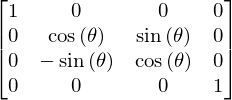

#### $\mathit{Rotate}_Y(\theta)$: Y軸を中心に回転

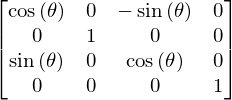

#### $\mathit{Rotate}_Z(\theta)$: Z軸を中心に回転

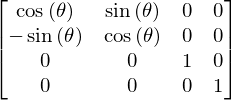

#### X, Y, Z軸を中心に45度回転

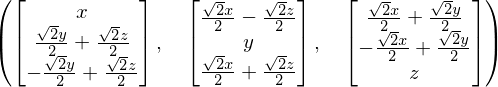

In [10]:
sp.var('theta')
c, s = sp.cos(theta), sp.sin(theta)

Symbolic['RotateX'] = sp.diag(1, sp.Matrix(2, 2, [ c, s, -s, c]), 1)
Symbolic['RotateY'] = sp.diag(sp.Matrix(3, 3, [ c, 0, -s, 0, 1, 0, s, 0, c ]), 1)
Symbolic['RotateZ'] = sp.diag(sp.Matrix(2, 2, [ c, s, -s, c ]), 1, 1)

Symbolic['rotateX'] = Symbolic['M32'](theta, Symbolic['RotateX'])
Symbolic['rotateY'] = Symbolic['M32'](theta, Symbolic['RotateY'])
Symbolic['rotateZ'] = Symbolic['M32'](theta, Symbolic['RotateZ'])

if __name__ == '__main__':
    for R in 'X Y Z'.split():
        Display.display_markdown('#### $\mathit{Rotate}_' + R + '(\\theta)$: ' + R + '軸を中心に回転', raw=True)
        display(Symbolic['Rotate' + R])
    
    Display.display_markdown('#### X, Y, Z軸を中心に45度回転', raw=True)
    display(tuple([Cartesian(Symbolic[R].subs({ theta: sp.pi / 4 }) *
                             Homogeneous(Vec3(x, y, z)))
                   for R in 'RotateX RotateY RotateZ'.split()]))

In [11]:
# Pythonで手書きで定義した回転変換API
def rotateX(theta):
    return mat4x4(
        1, 0, 0, 0,
        0, cos(theta), sin(theta), 0,
        0, -sin(theta), cos(theta), 0,
        0, 0, 0, 1)

def rotateY(theta):
    return mat4x4(
        cos(theta), 0, -sin(theta), 0,
        0, 1, 0, 0,
        sin(theta), 0, cos(theta), 0,
        0, 0, 0, 1)

def rotateZ(theta):
    return mat4x4(
    cos(theta), sin(theta), 0, 0,
    -sin(theta), cos(theta), 0, 0,
    0, 0, 1, 0,
    0, 0, 0, 1)

if __name__ == '__main__':
    # SymPyから自動生成したAPIと手書きのPythonコードが同一の回転行列を与えることの確認
    _theta = random.random()
    assert np.array_equal(rotateX(_theta), Symbolic['rotateX'](_theta))
    assert np.array_equal(rotateY(_theta), Symbolic['rotateY'](_theta))
    assert np.array_equal(rotateZ(_theta), Symbolic['rotateZ'](_theta))

## 並行移動変換 (Translate)

並行移動変換行列$\mathrm {Translate}(t_x, t_y, t_z)$に同次座標を乗ずると，その座標を$X, Y, Z$軸方向にそれぞれ$t_x, t_y, t_z$だけ並行移動した点の同次座標を与えます．

In [12]:
[tx, ty, tz] = TranslateSymbols = sp.symbols('t_x t_y t_z')
Symbolic['Translate'] = sp.eye(3).row_join(sp.Matrix(TranslateSymbols)).col_join(sp.Matrix([[0, 0, 0, 1]]))
Symbolic['translate'] = Symbolic['M32'](TranslateSymbols, Symbolic['Translate'])

if __name__ == '__main__':
    p = Homogeneous(Vec3(x, y, z))

    md('#### 並行移動行列')
    md('$\mathrm {Translate}(t_x, t_y, t_z)', p, '=',
       Symbolic['Translate'], p, '=',
       Symbolic['Translate'] * p, '$')

#### 並行移動行列

$\mathrm {Translate}(t_x, t_y, t_z)\left[\begin{matrix}x\\y\\z\\1\end{matrix}\right]=\left[\begin{matrix}1 & 0 & 0 & t_{x}\\0 & 1 & 0 & t_{y}\\0 & 0 & 1 & t_{z}\\0 & 0 & 0 & 1\end{matrix}\right]\left[\begin{matrix}x\\y\\z\\1\end{matrix}\right]=\left[\begin{matrix}t_{x} + x\\t_{y} + y\\t_{z} + z\\1\end{matrix}\right]$

In [13]:
# Pythonで手書きで定義した平行移動変換API
def translate(tx, ty, tz):
    return np.hstack((np.vstack((np.eye(3),
                                 np.zeros((1, 3)))),
                      vec4(tx, ty, tz, 1).reshape(4, 1)))

if __name__ == '__main__':
    # SymPyから自動生成したAPIと手書きのPythonコードが同一の平行移動行列を与えることの確認
    t = rand(3)
    assert np.array_equal(translate(*t), Symbolic['translate'](*t))

## 空間変換のための関数群

### 視野変換 (LookAt)

視野変換は**全体座標系** (*Global coordinate system*)に配置されたオブジェクトを観察者の立場から眺めたときの様子，すなわち**視野座標系**(*Viewing coordinate system*)に変換します．観察者の立ち位置を表現するために観察者の視点(*eye*)，観察者の視線の先の点(*center*)，そして観察者の頭の向き(*up*)を与えます．

視野変換は全体座標系を視点に平行移動する変換$T$と，視線の向きを$Z$軸方向から視線の向きに回転する変換$R$を合成($R \cdot T$)したものと考えられます．

まず，平行移動は原点を移転に移動する変換で，特に$\mathit {eye}$を原点に移動する移動です．移動のベクトルは$(0 - \mathit {eye}) = -\mathit {eye}$ですので，変換行列は以下のように与えられます．

$$T = \mathrm {Translate}(-\mathit {eye}) = \begin {pmatrix}
  1 & 0 & 0 & -\mathit {eye}_x \\
  0 & 1 & 0 & -\mathit {eye}_y \\
  0 & 0 & 1 & -\mathit {eye}_z \\
  0 & 0 & 0 & 1
\end {pmatrix}$$

次に回転変換$R$ですが，視野座標系を定める3つの軸は，視線の向き(*Forward*)，頭の向き(*Head*)，そして両者に直交する横方向の向き(*Side*)で構成できそうなのですが，一般には視線の向きと頭の向きが直交しているとは限りません．そこで，3軸は以下のように取ります．

- 視線の向き ($F$): $(\mathit {center} - \mathit {eye})$
- 横の向き ($S$): 「視線の向き」と「頭の向き」に直交するベクトル
- 上の向き ($H$): 「横の向き」と「視線の向き」に直交するベクトル

すなわち，
$$F = \mathit {normalize}(\mathit {center} - \mathit {eye}) \qquad
  S = \mathit {normalize}(F \times \mathit {up}) \qquad
  H = S \times F$$
  
回転行列$R$は，$S, H, F$をそれぞれ$X, Y, Z$軸方向の単位ベクトル($e_X, e_Y, e_Z$)軸に射影します．さて，逆に$R$の逆回転$R^{-1}$は$(e_x, e_y, e_z)$をそれぞれ$S, H, F$に射影する回転行列となります．この逆回転行列は，以下のものになることは簡単に確認することができるでしょう．

$$R^{-1} = \begin {pmatrix}
S_0 & H_0 & F_0 & 0 \\
S_1 & H_1 & F_1 & 0 \\
S_2 & H_2 & F_2 & 0 \\
0   & 0   & 0   & 1
\end {pmatrix}$$

目的とする行列はこれの逆行列です．$F, S, H$の定義より，これらのベクトルは正規直交基底を構成しますので，$R^{-1}$も正規直交行列であることが簡単に確認できます．正規直交行列の逆行列は，その行列の転置行列と等しいので，求める$R$は以下のものです．

$$R = (R^{-1})^T = \begin {pmatrix}
  S_0 & S_1 & S_2 & 0 \\
  H_0 & H_1 & H_2 & 0 \\
  F_0 & F_1 & F_2 & 0 \\
  0   & 0   & 0   & 1
\end {pmatrix}$$

視野変換行列$\mathit {LookAt}$は，$T$と$R$を合成して以下のように与えることができます．

$$\mathit {LookAt} = R \cdot T = \begin {pmatrix}
  S_0 & S_1 & S_2 & -S \cdot \mathit {eye} \\
  H_0 & H_1 & H_2 & -H \cdot \mathit {eye} \\
  F_0 & F_1 & F_2 & -F \cdot \mathit {eye} \\
  0 & 0 & 0 & 1
\end {pmatrix}$$

ただし，CGやOpenGLでは，全体座標系に右手系を用いる一方，視野座標系には左手系を用いることが一般的です．このため，以下のPythonでの実装では，`F = -F`として右手系から左手系への変換を実施しています．

In [14]:
LookAtVectors = [Eye, Side, Head, Forward] = [
    sp.var('I_x I_y I_z'), sp.var('S_x S_y S_z'),
    sp.var('H_x H_y H_z'), sp.var('F_x F_y F_z')]
[I, S, H, F] = [sp.Matrix(3, 1, M) for M in LookAtVectors]

LookAtTranslate = Symbolic['Translate'].subs({ tx: -I_x, ty: -I_y, tz: -I_z })
invLookAtRotate = sp.Matrix(sp.BlockMatrix([[S, H, -F, sp.zeros(3, 1)]])).col_join(sp.Matrix([[0, 0, 0, 1]]))
LookAtRotate = invLookAtRotate.T  # 回転行列は正規直交行列なので，逆行列は転置行列

Symbolic['LookAt'] = LookAtRotate * LookAtTranslate

__lookat__ = Symbolic['M32'](Eye + Forward + Side + Head, Symbolic['LookAt'])
def __lookAtAux__(eye, center, up):
    i = eye
    f = normalize(center - eye)
    s = normalize(np.cross(f, up))
    h = np.cross(s, f)
    return __lookat__(i[0], i[1], i[2],
                      f[0], f[1], f[2],
                      s[0], s[1], s[2],
                      h[0], h[1], h[2])
Symbolic['lookat'] = __lookAtAux__

if __name__ == '__main__':
    md('#### 視点へのカメラの移動 (LookAtTranslate)\n',
       'まず，視点($I$)を原点に移動する平行変換です．',
       '$$\\mathrm {LookAtTranslate} = \\mathrm {Translate}(-I) =',
       LookAtTranslate, '$$')
    
    md('この変換が視点を原点に移動することを確認してみましょう．$$',
       '\\mathrm {LookAtTranslate} \\cdot', Homogeneous(I), '=',
       LookAtTranslate, '\\cdot', Homogeneous(I), '=',
       LookAtTranslate * Homogeneous(I), '$$')

    md('#### 視線の設定 (LookAtRotate)\n',
       'つぎに，逆回転変換は標準的な基底を$S, H, -F$に移動します．',
       'ここで$-F$と反転しているのは，全体座標系は右手系で与え，視野座標系は左手系で与える慣習に沿ったためです．',
       '$$',
       '\\mathrm {LookAtRotate}^{-1} = ', invLookAtRotate, '$$',
       'では，この逆回転変換が実際に基底ベクトルを$S, H, F$に写すか確認してみましょう．$$\\left(',
       Vec3(1, 0, 0), '\mapsto', Cartesian(invLookAtRotate * Homogeneous(Vec3(1, 0, 0))), ',',
       Vec3(0, 1, 0), '\mapsto', Cartesian(invLookAtRotate * Homogeneous(Vec3(0, 1, 0))), ',',
       Vec3(0, 0, 1), '\mapsto', Cartesian(invLookAtRotate * Homogeneous(Vec3(0, 0, 1))),
       '\\right)$$')
    md('逆回転変換の逆行列が求めたい回転変換なのです．$S, H, F$は標準化され，相互に直交しています．',
       'したがって，この変換は正規直交変換ということになります．',
       '正規直交変換の逆行列は転置行列になるので，視野変換の回転行列は以下のようになります．$$',
       '\\mathrm {LookAtRotate} =',
       '(\\mathrm {LookAtRotate}^{-1})^{-1} =',
       '(\\mathrm {LookAtRotate}^{-1})^T =',
       invLookAtRotate, '^T =', LookAtRotate, '$$')

    md('#### 視野変換 (LookAt行列)')
    md('平行移動行列と回転行列を合成することで視野変換行列が得られます．$$',
       '\\mathrm {LookAt} = \\mathrm {LookAtRotate} \\cdot \\mathrm {LookAtTranslate} =',
       Symbolic['LookAt'], '$$')

#### 視点へのカメラの移動 (LookAtTranslate)
まず，視点($I$)を原点に移動する平行変換です．$$\mathrm {LookAtTranslate} = \mathrm {Translate}(-I) =\left[\begin{matrix}1 & 0 & 0 & - I_{x}\\0 & 1 & 0 & - I_{y}\\0 & 0 & 1 & - I_{z}\\0 & 0 & 0 & 1\end{matrix}\right]$$

この変換が視点を原点に移動することを確認してみましょう．$$\mathrm {LookAtTranslate} \cdot\left[\begin{matrix}I_{x}\\I_{y}\\I_{z}\\1\end{matrix}\right]=\left[\begin{matrix}1 & 0 & 0 & - I_{x}\\0 & 1 & 0 & - I_{y}\\0 & 0 & 1 & - I_{z}\\0 & 0 & 0 & 1\end{matrix}\right]\cdot\left[\begin{matrix}I_{x}\\I_{y}\\I_{z}\\1\end{matrix}\right]=\left[\begin{matrix}0\\0\\0\\1\end{matrix}\right]$$

#### 視線の設定 (LookAtRotate)
つぎに，逆回転変換は標準的な基底を$S, H, -F$に移動します．ここで$-F$と反転しているのは，全体座標系は右手系で与え，視野座標系は左手系で与える慣習に沿ったためです．$$\mathrm {LookAtRotate}^{-1} = \left[\begin{matrix}S_{x} & H_{x} & - F_{x} & 0\\S_{y} & H_{y} & - F_{y} & 0\\S_{z} & H_{z} & - F_{z} & 0\\0 & 0 & 0 & 1\end{matrix}\right]$$では，この逆回転変換が実際に基底ベクトルを$S, H, F$に写すか確認してみましょう．$$\left(\left[\begin{matrix}1\\0\\0\end{matrix}\right]\mapsto\left[\begin{matrix}S_{x}\\S_{y}\\S_{z}\end{matrix}\right],\left[\begin{matrix}0\\1\\0\end{matrix}\right]\mapsto\left[\begin{matrix}H_{x}\\H_{y}\\H_{z}\end{matrix}\right],\left[\begin{matrix}0\\0\\1\end{matrix}\right]\mapsto\left[\begin{matrix}- F_{x}\\- F_{y}\\- F_{z}\end{matrix}\right]\right)$$

逆回転変換の逆行列が求めたい回転変換なのです．$S, H, F$は標準化され，相互に直交しています．したがって，この変換は正規直交変換ということになります．正規直交変換の逆行列は転置行列になるので，視野変換の回転行列は以下のようになります．$$\mathrm {LookAtRotate} =(\mathrm {LookAtRotate}^{-1})^{-1} =(\mathrm {LookAtRotate}^{-1})^T =\left[\begin{matrix}S_{x} & H_{x} & - F_{x} & 0\\S_{y} & H_{y} & - F_{y} & 0\\S_{z} & H_{z} & - F_{z} & 0\\0 & 0 & 0 & 1\end{matrix}\right]^T =\left[\begin{matrix}S_{x} & S_{y} & S_{z} & 0\\H_{x} & H_{y} & H_{z} & 0\\- F_{x} & - F_{y} & - F_{z} & 0\\0 & 0 & 0 & 1\end{matrix}\right]$$

#### 視野変換 (LookAt行列)

平行移動行列と回転行列を合成することで視野変換行列が得られます．$$\mathrm {LookAt} = \mathrm {LookAtRotate} \cdot \mathrm {LookAtTranslate} =\left[\begin{matrix}S_{x} & S_{y} & S_{z} & - I_{x} S_{x} - I_{y} S_{y} - I_{z} S_{z}\\H_{x} & H_{y} & H_{z} & - H_{x} I_{x} - H_{y} I_{y} - H_{z} I_{z}\\- F_{x} & - F_{y} & - F_{z} & F_{x} I_{x} + F_{y} I_{y} + F_{z} I_{z}\\0 & 0 & 0 & 1\end{matrix}\right]$$

In [15]:
def lookat(eye, center, up):
    # Forward, Side, and Head
    F = normalize(center - eye)
    S = normalize(np.cross(F, up))
    U = np.cross(S, F)
    # 全体座標系では右手系を用い，視野座標系には左手系を用いるのが慣習
    F = -F
    return mat4x4(
        S[0], S[1], S[2], -np.dot(S, eye),
        U[0], U[1], U[2], -np.dot(U, eye),
        F[0], F[1], F[2], -np.dot(F, eye),
        0,    0,    0,     1)

'''# GLM implementation
template <typename T, precision P> GLM_FUNC_QUALIFIER tmat4x4<T, P>
lookAt (tvec3<T, P> const & eye, tvec3<T, P> const & center, tvec3<T, P> const & up) {
    tvec3<T, P> const f(normalize(center - eye));
    tvec3<T, P> const s(normalize(cross(f, up)));
    tvec3<T, P> const u(cross(s, f));

    tmat4x4<T, P> Result(1);
    Result[0][0] = s.x; Result[1][0] = s.y; Result[2][0] = s.z;
    Result[0][1] = u.x; Result[1][1] = u.y; Result[2][1] = u.z;
    Result[0][2] =-f.x; Result[1][2] =-f.y; Result[2][2] =-f.z;
    Result[3][0] =-dot(s, eye); Result[3][1] =-dot(u, eye); Result[3][2] = dot(f, eye);
    return Result;
}'''

if __name__ == '__main__':
    eye    = vec3(5, 5, 5) # 視点
    center = vec3(5, 5, 0) # 投影面上の点：XY平面を正面から眺める
    up     = vec3(0, 1, 0) # Y軸方向を頭の向きとする
    LookAt = lookat(eye, center, up)
    
    assert np.array_equal(lookat(eye, center, up),
                          Symbolic['lookat'](eye, center, up))

## 正射影 (Orthographic transformation)

正射影は空間から視線を中心線とする直方体領域を切り取り，それを原点を中心とした一辺の長さが2の立方体に射影します．直方体は視点から見たときの幅(*width*)と高さ(*height*)に加えて，直方体の手前と奥の面に対応する$Z$座標の値として，それぞれ$Z_{\mathit {near}}$と$Z_{\mathit {far}}$によって与えられます．

この変換は，直方体の中心座標($(0, 0, (Z_{\mathit {near}} + Z_{\mathit {far}}) / 2)$)を原点に移動する平行移動変換($T$)と直方体を立方体に拡縮を施す変換($S$)を合成したものと考えることができます．ここでの拡縮で視野座標系で用いていた左手系を右手系に戻します．この系の変更は，拡縮行列の計算にあたって$Z$軸についての拡縮率の符号を反転させている点に注意して下さい．

$$
\begin {align}
T &= \mathrm {Translate}\left(0, 0, -\left(Z_{\mathit {near}} + Z_{\mathit {far}}\right) / 2\right) \\
  &= \begin {pmatrix}
  1 & 0 & 0 & 0 \\
  0 & 1 & 0 & 0 \\
  0 & 0 & 1 & -(Z_{\mathit {near}} + Z_{\mathit {far}}) / 2 \\
  0 & 0 & 0 & 1
\end {pmatrix} \\
%
S &= \mathrm {Scale}\left(\frac 2 {\mathit {width}}, \frac 2 {\mathit {height}},  -2/\left(\frac {Z_{\mathit {far}} - Z_{\mathit {near}}} 2\right)\right) \\
  &= 2 \begin {pmatrix}
        \frac 1 {\mathit {width}} & 0 & 0 & 0 \\
        0 & \frac 1 {\mathit {height}} & 0 & 0 \\
        0 & 0 & -\frac 2 {Z_{\mathit {far}} - Z_{\mathit {near}}} & 0 \\
        0 & 0 & 0 & 1
      \end {pmatrix}
\end {align}$$

これらを合成することで，正射影を表す$\mathrm {Ortho}$行列は以下のように表現できる．
$$\begin {align}
\mathrm {Ortho} &= S \cdot T \\
  &= \begin {pmatrix}
       \frac 2 {\mathit {width}} & 0 & 0 & 0 \\
       0 & \frac 2 {\mathit {height}} & 0 & 0 \\
       0 & 0 & - \frac 2 {Z_{\mathit {far}} - Z_{\mathit {near}}} & - \frac {Z_{\mathit {far}} + Z_{\mathit {near}}} {Z_{\mathit {far} - Z_{\mathit {near}}}} \\
       0 & 0 & 0 & 1
     \end {pmatrix}
\end {align}$$

In [16]:
sp.var('width, height')
[near, far] = sp.symbols('Z_{near}, Z_{far}')

[tx, ty, tz] = TranslateSymbols

OrthoTranslate = Symbolic['Translate'].subs({ tx: 0, ty: 0, tz: (-(near + far)/2) })
OrthoScale = sp.diag(2/width, 2/height, -2/(far - near), 1)
Symbolic['Orthographic'] = OrthoScale * OrthoTranslate
Symbolic['orthographic'] = Symbolic['M32']((width, height, near, far), Symbolic['Orthographic'])

if __name__ == '__main__':
    md('#### 平行移動変換行列\n\n$',
        '\\mathrm {OrthoTranslate} =', OrthoTranslate, '$')

    md('平行移動変換によって直方体の中心$(0, 0, (near + far)/2)$が原点に移動することを確認してみましょう．')
    md('$$\\mathrm {OrthoTranslate}(\\mathit {near}, \\mathit {far})',
       Homogeneous(Vec3(0, 0, (near + far)/2)), '=',
       OrthoTranslate, '\\cdot', Homogeneous(Vec3(0, 0, (near + far)/2)), '=',
       OrthoTranslate * Homogeneous(Vec3(0, 0, (near + far)/2)), '$$')

    md('#### 拡大縮小行列\n\n$$',
       '\mathrm {OrthoScale} =', OrthoScale, '$$')

    md('これらの行列を合成することで正射影を表す$\mathrm {Orthographic}$行列を定義できます．')


    md('$$\\mathrm {Orthographic} = \\mathrm {OrthoScale} \cdot \\mathrm {OrthoTranslate} =',
       Symbolic['Orthographic'], '$$')

    [p1, p2] = [Homogeneous(p) for p in [Vec3( width/2,  height/2, near),
                                         Vec3(-width/2, -height/2, far)]]

    md('では，正射影によって直方体の対角線が立方体の対角線に射影されることを確認してみましょう．$$',
       '\\mathrm {Orthographic} \cdot', Homogeneous(Vec3(width/2, height/2, near)), '=',
       sp.simplify(Cartesian(Symbolic['Orthographic'] * p1)), '\\qquad',
   
       '\\mathrm {Orthographic} \cdot', Homogeneous(Vec3(-width/2, -height/2, far)), '=',
       sp.simplify(Cartesian(Symbolic['Orthographic'] * p2)), '$$')

#### 平行移動変換行列

$\mathrm {OrthoTranslate} =\left[\begin{matrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\0 & 0 & 1 & - \frac{Z_{{far}}}{2} - \frac{Z_{{near}}}{2}\\0 & 0 & 0 & 1\end{matrix}\right]$

平行移動変換によって直方体の中心$(0, 0, (near + far)/2)$が原点に移動することを確認してみましょう．

$$\mathrm {OrthoTranslate}(\mathit {near}, \mathit {far})\left[\begin{matrix}0\\0\\\frac{Z_{{far}}}{2} + \frac{Z_{{near}}}{2}\\1\end{matrix}\right]=\left[\begin{matrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\0 & 0 & 1 & - \frac{Z_{{far}}}{2} - \frac{Z_{{near}}}{2}\\0 & 0 & 0 & 1\end{matrix}\right]\cdot\left[\begin{matrix}0\\0\\\frac{Z_{{far}}}{2} + \frac{Z_{{near}}}{2}\\1\end{matrix}\right]=\left[\begin{matrix}0\\0\\0\\1\end{matrix}\right]$$

#### 拡大縮小行列

$$\mathrm {OrthoScale} =\left[\begin{matrix}\frac{2}{width} & 0 & 0 & 0\\0 & \frac{2}{height} & 0 & 0\\0 & 0 & - \frac{2}{Z_{{far}} - Z_{{near}}} & 0\\0 & 0 & 0 & 1\end{matrix}\right]$$

これらの行列を合成することで正射影を表す$\mathrm {Orthographic}$行列を定義できます．

$$\mathrm {Orthographic} = \mathrm {OrthoScale} \cdot \mathrm {OrthoTranslate} =\left[\begin{matrix}\frac{2}{width} & 0 & 0 & 0\\0 & \frac{2}{height} & 0 & 0\\0 & 0 & - \frac{2}{Z_{{far}} - Z_{{near}}} & - \frac{- Z_{{far}} - Z_{{near}}}{Z_{{far}} - Z_{{near}}}\\0 & 0 & 0 & 1\end{matrix}\right]$$

では，正射影によって直方体の対角線が立方体の対角線に射影されることを確認してみましょう．$$\mathrm {Orthographic} \cdot\left[\begin{matrix}\frac{width}{2}\\\frac{height}{2}\\Z_{{near}}\\1\end{matrix}\right]=\left[\begin{matrix}1\\1\\1\end{matrix}\right]\qquad\mathrm {Orthographic} \cdot\left[\begin{matrix}- \frac{width}{2}\\- \frac{height}{2}\\Z_{{far}}\\1\end{matrix}\right]=\left[\begin{matrix}-1\\-1\\-1\end{matrix}\right]$$

In [17]:
def ortho(left, right, bottom, top, zNear=-1, zFar=1):
    rl, tb, fn = right - left, top - bottom, zFar - zNear
    return mat4x4(
            2/rl, 0, 0, -(right + left)/rl,
            0, 2/tb, 0, -(top + bottom)/tb,
            0, 0, -2/fn, -(zFar + zNear)/fn,
            0, 0, 0, 1)

''' GLM Implementation

template <typename T> GLM_FUNC_QUALIFIER tmat4x4<T, defaultp>
ortho (T left, T right, T bottom, T top, T zNear, T zFar) {
    tmat4x4<T, defaultp> Result(1);
    Result[0][0] = static_cast<T>(2) / (right - left);
    Result[1][1] = static_cast<T>(2) / (top - bottom);
    Result[2][2] = - static_cast<T>(2) / (zFar - zNear);
    Result[3][0] = - (right + left) / (right - left);
    Result[3][1] = - (top + bottom) / (top - bottom);
    Result[3][2] = - (zFar + zNear) / (zFar - zNear);
    return Result;
}

template <typename T> GLM_FUNC_QUALIFIER tmat4x4<T, defaultp>
ortho (T left, T right, T bottom, T top) {
    tmat4x4<T, defaultp> Result(1);
    Result[0][0] = static_cast<T>(2) / (right - left);
    Result[1][1] = static_cast<T>(2) / (top - bottom);
    Result[2][2] = - static_cast<T>(1);
    Result[3][0] = - (right + left) / (right - left);
    Result[3][1] = - (top + bottom) / (top - bottom);
    return Result;
}'''

if __name__ == '__main__':
    assert(np.array_equal(ortho(-400, 400, -300, 300, zNear=-1, zFar=1),
                          Symbolic['orthographic'](800, 600, -1, 1)))

## 錐台変換？ (Frustum transformation)

正射影との違いを理解していない．．．式は異なるようだが，何をしている？？？

In [18]:
def frustum(left, right, bottom, top, near, far):
    rl, tb, fn = right - left, top - bottom, far - near
    return mat4x4(
            2 * near / rl, 0, (right + left) / rl, 0,
            0, 2 * near / tb, (top + bottom) / tb, 0,
            0, 0, -(far + near) / fn, -2 * far * near / fn,
            0, 0, 0, 0)

''' GLM implementation
template <typename T> GLM_FUNC_QUALIFIER tmat4x4<T, defaultp>
frustum (T left, T right, T bottom, T top, T nearVal, T farVal) {
    tmat4x4<T, defaultp> Result(0);
    Result[0][0] = (static_cast<T>(2) * nearVal) / (right - left);
    Result[1][1] = (static_cast<T>(2) * nearVal) / (top - bottom);
    Result[2][0] = (right + left) / (right - left);
    Result[2][1] = (top + bottom) / (top - bottom);
    Result[2][2] = -(farVal + nearVal) / (farVal - nearVal);
    Result[2][3] = static_cast<T>(-1);
    Result[3][2] = -(static_cast<T>(2) * farVal * nearVal) / (farVal - nearVal);
    return Result;
}
'''

if __name__ == '__main__':
    print('Frustum(0, 10, 0, 10, 2, 12):\n{0}'.format(frustum(0, 10, 0, 10, 2, 12)))

Frustum(0, 10, 0, 10, 2, 12):
[[ 0.40000001  0.          1.          0.        ]
 [ 0.          0.40000001  1.          0.        ]
 [ 0.          0.         -1.39999998 -4.80000019]
 [ 0.          0.          0.          0.        ]]


## 透視投影 (Perspective transformation)

透視投影は，視点から視る錐台を立方体に射影する変換であり，遠近法を表現するものである．透視投影は視野角(*fovy*)，アスペクト比(*aspect*)，そして正射影と同様に奥行方向に切り取るための*near*と*far*を用いる．視野角はラジアンによって左右方向の視野を定める．この視野角とアスペクト比によって上下方向の視野角が定まる．

In [19]:
def perspective(fovy, aspect, near, far):
    tFovy2 = tan(fovy / 2)
    return mat4x4(
            1 / (aspect * tFovy2), 0, 0, 0,
            0, 1 / tFovy2, 0, 0,
            0, 0, -(far + near) / (far - near), -2 * far * near / (far - near),
            0, 0, -1, 0)

#def perspective(fovy, aspect, near, far):
#    s = 1 / tan(fovy / 2 * np.pi / 180)
#    M = np.diag([s, s, - float(far + near) / float(far - near), 0])
#    M[2][3] = -1; M[3][2] = - 2 * far * near / float(far - near)
#    return M.astype(np.float32)

''' GLM implementation
template <typename T> GLM_FUNC_QUALIFIER tmat4x4<T, defaultp>
perspective (T fovy, T aspect, T zNear, T zFar) {
    assert(abs(aspect - std::numeric_limits<T>::epsilon()) > static_cast<T>(0));

    T const tanHalfFovy = tan(fovy / static_cast<T>(2));

    tmat4x4<T, defaultp> Result(static_cast<T>(0));
    Result[0][0] = static_cast<T>(1) / (aspect * tanHalfFovy);
    Result[1][1] = static_cast<T>(1) / (tanHalfFovy);
    Result[2][2] = - (zFar + zNear) / (zFar - zNear);
    Result[2][3] = - static_cast<T>(1);
    Result[3][2] = - (static_cast<T>(2) * zFar * zNear) / (zFar - zNear);
    return Result;
}'''


if __name__ == '__main__':
    print('Perspective(np.pi / 3, 1, 2, 12):\n{0}'.format(perspective(np.pi / 3, 1, 2, 12)))

Perspective(np.pi / 3, 1, 2, 12):
[[ 1.73205078  0.          0.          0.        ]
 [ 0.          1.73205078  0.          0.        ]
 [ 0.          0.         -1.39999998 -4.80000019]
 [ 0.          0.         -1.          0.        ]]


In [20]:
def perspectiveFov(fov, width, height, near, far):
    h = cos(fov/2) / sin(fov/2)
    w = h * height / width
    return mat4x4(
            w, 0, 0, 0,
            0, h, 0, 0,
            0, 0, -(far + near) / (far - near), -1, 
            0, 0, -2 * far * near / (far - near))

'''GLM implementation
template <typename T> GLM_FUNC_QUALIFIER tmat4x4<T, defaultp>
perspectiveFov (T fov, T width, T height, T zNear, T zFar) {
    assert(width > static_cast<T>(0));
    assert(height > static_cast<T>(0));
    assert(fov > static_cast<T>(0));

    T const rad = fov;
    T const h = glm::cos(static_cast<T>(0.5) * rad) / glm::sin(static_cast<T>(0.5) * rad);
    T const w = h * height / width; ///todo max(width , Height) / min(width , Height)?

    tmat4x4<T, defaultp> Result(static_cast<T>(0));
    Result[0][0] = w;
    Result[1][1] = h;
    Result[2][2] = - (zFar + zNear) / (zFar - zNear);
    Result[2][3] = - static_cast<T>(1);
    Result[3][2] = - (static_cast<T>(2) * zFar * zNear) / (zFar - zNear);
    return Result;
}'''

if __name__ == '__main__':
    pass

In [21]:
def project(obj, Model, Proj, viewport):
    V = Proj.dot(Model.dot(obj))
    V = V / V[3] / 2 + 0.5
    V[0] = V[0] * viewport[2] + viewport[0]
    V[1] = V[1] * viewport[3] + viewport[1]
    return V

'''GLM implementation
template <typename T, typename U, precision P> GLM_FUNC_QUALIFIER tvec3<T, P>
project (tvec3<T, P> const & obj, tmat4x4<T, P> const & model, tmat4x4<T, P> const & proj, tvec4<U, P> const & viewport) {
    tvec4<T, P> tmp = tvec4<T, P>(obj, T(1));
    tmp = model * tmp;
    tmp = proj * tmp;

    tmp /= tmp.w;
    tmp = tmp * T(0.5) + T(0.5);
    tmp[0] = tmp[0] * T(viewport[2]) + T(viewport[0]);
    tmp[1] = tmp[1] * T(viewport[3]) + T(viewport[1]);

    return tvec3<T, P>(tmp);
}'''

if __name__ == '__main__':
#    print('Project(obj, Model, Proj, viewport):\n{0}'.format(perspective(np.pi / 3, 1, 2, 12)))
    pass